# Lectura

In [ ]:
import pandas as pd
import os
import gc
import pyarrow.feather as feather

df=pd.DataFrame()
directory = '/content/drive/MyDrive/TFM/'
for filename in os.listdir(directory):
  if filename.endswith(".feather"):
      filepath = os.path.join(directory, filename)
      df_temp = pd.read_feather(filepath)
      df_temp.drop(columns=['x_pos', 'y_pos'], inplace = True)
      df_temp['target']=filename.split('_')[0]
      df = pd.concat([df,df_temp], ignore_index=True)
      del df_temp
      gc.collect()
      print(filename+' joined')

X=df.drop(columns=['target'])
y=df['target']

gc.collect()

ALL B Ph+_1_1.feather joined
ALL B Ph-_1_1.feather joined
ALL T_1_1.feather joined
AML M0_1_2.feather joined
AML M1_1_1.feather joined
AML M2_1_1.feather joined
AML M3_1_1.feather joined
AML M5a_1_1.feather joined
AML M6_1_1.feather joined


0

# Preprocesado

## Preprocesado obligatorio (acotar frecuencias y vector de frecuencias equidistante de 2 cm⁻¹)

In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

def sep_2cm(X):
    X.columns = X.columns.astype(float)
    X=X.interpolate(method='index', limit_direction='both', axis=1) #Nos deshacemos de NaNs

    # Definimos una nueva lista de frecuencias con separación de 2 cm⁻¹
    wavenumbers = X.columns

    # Definimos una nueva lista de frecuencias con separación de 2 cm⁻¹
    new_wavenumbers = np.arange(start=wavenumbers.min(), stop=wavenumbers.max(), step=2)

    # Creamos un DataFrame vacío para almacenar los datos interpolados
    X_step = pd.DataFrame(columns=new_wavenumbers)

    # Interpolamos cada columna del DataFrame X
    for index, row in X.iterrows():
        intensities = row.values
        interpolator = interp1d(wavenumbers, intensities, kind='linear', fill_value="extrapolate")
        new_intensities = interpolator(new_wavenumbers)
        X_step.loc[index] = new_intensities
    return X_step

In [ ]:
def acotar(X, truncation_min, truncation_max):
    data_copy = X.copy()
    data_copy.columns = data_copy.columns.astype(float)
    wavenumbers = data_copy.columns
    wavenumbers_filtered = wavenumbers[(wavenumbers >= truncation_min) & (wavenumbers <= truncation_max)]

    return data_copy[wavenumbers_filtered.astype(float)]

In [ ]:
X_pre = sep_2cm(acotar(df,550,3100))

In [ ]:
#X_pre.to_feather('/content/drive/MyDrive/TFM/preprocesado/X_obligatorio.feather') #guaradmos en disco para usarlo depues

In [ ]:
import pandas as pd
X_pre = pd.read_feather('/content/drive/MyDrive/TFM/preprocesado/X_obligatorio.feather') #cargamos el feather guardado previamente  si es necesario

In [ ]:
X_pre

,550.52026,552.52026,554.52026,556.52026,558.52026,560.52026,562.52026,564.52026,566.52026,568.52026,...,3080.52026,3082.52026,3084.52026,3086.52026,3088.52026,3090.52026,3092.52026,3094.52026,3096.52026,3098.52026
0,28.995710,34.935449,31.842764,31.680421,26.417784,28.858629,29.887627,32.925023,38.213969,35.177332,...,205.164185,203.049788,205.757240,195.610767,188.286502,191.846101,226.886312,232.355851,221.886168,203.309601
1,28.159023,35.952655,33.703928,32.029490,35.792795,35.707086,23.646416,34.253074,34.186327,35.315157,...,199.709256,219.988590,199.473717,204.120878,212.108578,217.368127,234.599242,225.425026,219.646005,233.378159
2,31.275982,30.423199,29.108172,32.508335,32.931335,24.105295,25.286462,24.287473,32.380025,34.007255,...,194.380364,182.589265,179.755882,189.191761,207.900111,230.906730,220.828878,207.767702,211.289904,241.568115
3,28.629328,32.191050,33.274833,32.321176,29.126927,31.675708,28.918365,29.849063,30.464074,33.181025,...,210.913132,228.698517,230.962172,209.736048,198.076328,207.551801,232.385121,245.842408,254.947928,263.191772
4,34.154732,30.358749,28.206415,33.620855,27.419311,28.406549,29.152284,25.919308,31.217492,29.878993,...,192.952585,190.908061,189.948150,200.722037,214.377916,225.133231,209.073370,219.853313,232.095338,231.773773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36859,31.061932,32.255193,35.956585,34.568819,33.901247,33.857931,35.804426,31.902469,30.785891,33.362958,...,173.735288,174.131097,179.491625,193.972177,187.862788,190.891787,194.548669,190.509005,195.377490,205.256573
36860,35.630032,33.760820,35.567480,36.105950,36.089690,35.544801,36.774446,34.742364,35.948563,35.467673,...,172.489402,175.015726,179.628291,187.818008,187.839106,191.444812,194.761709,193.951092,196.246241,201.995337
36861,38.036789,35.979316,34.809533,36.781119,34.646460,36.791322,35.621377,34.823373,35.792475,35.417152,...,168.000439,176.293111,183.615512,186.537559,191.347147,193.683057,195.034771,196.783213,200.978916,206.096314
36862,36.713734,37.895526,37.931970,35.336973,36.614967,35.613472,35.657778,37.878002,36.154397,36.615222,...,170.725696,175.450877,176.390461,172.283746,182.974999,187.482490,190.306710,195.732348,196.050060,201.331174


## Tratamiento del background

In [ ]:
def background(data, clustering_min=2800, clustering_max=3030):
    from sklearn.cluster import KMeans
    from scipy.ndimage import label, binary_erosion, generate_binary_structure
    import numpy as np
    import pandas as pd

    # Convertir las columnas del DataFrame a tipo float para asegurar que los tipos son correctos
    data_copy = data.copy()
    data_copy.columns = data_copy.columns.astype(float)
    wavenumbers = data_copy.columns

    # Filtrar las frecuencias dentro del rango especificado
    wavenumbers_clustering = wavenumbers[(wavenumbers >= clustering_min) & (wavenumbers <= clustering_max)]
    data_clustering = data_copy[wavenumbers_clustering]

    # Realizar k-means con 4 clusters
    kmeans = KMeans(n_clusters=4, n_init='auto', random_state=42)
    clusters = kmeans.fit_predict(data_clustering)

    # Encontrar el cluster con la media de intensidad más baja
    cluster_means = pd.DataFrame(data_clustering).groupby(clusters).mean().mean(axis=1)
    background_cluster = cluster_means.idxmin()

    # Calcular el espectro medio del cluster con la media de intensidad más baja
    background_spectra = data_copy[clusters == background_cluster]
    background_median_spectrum = background_spectra.median()

    # Se resta el espectro de fondo del DataFrame original y luego se aplica np.maximum para asegurarse de que no haya valores negativos
    data_corrected = np.maximum(0, data_copy - background_median_spectrum)

    # Excluir los datos del cluster de fondo del conjunto de datos corregido
    foreground_data = data_corrected[clusters != background_cluster]

    # Generar una máscara para los datos de primer plano
    foreground_mask = np.ones(len(foreground_data), dtype=bool)

    # Identificar y eliminar pequeñas regiones aisladas (componentes conectados con menos de 64 píxeles)
    structure = generate_binary_structure(1, 1)
    labeled_array, num_features = label(foreground_mask, structure=structure)
    sizes = np.bincount(labeled_array.ravel())
    mask_sizes = sizes >= 64
    mask_sizes[0] = 0  # Ignorar el fondo
    foreground_mask = mask_sizes[labeled_array]

    # Aplicar erosión morfológica a la máscara del primer plano
    foreground_mask_eroded = binary_erosion(foreground_mask, structure=np.ones((3,)))

    # Aplicar la máscara final a los datos corregidos
    return foreground_data.loc[foreground_mask_eroded]


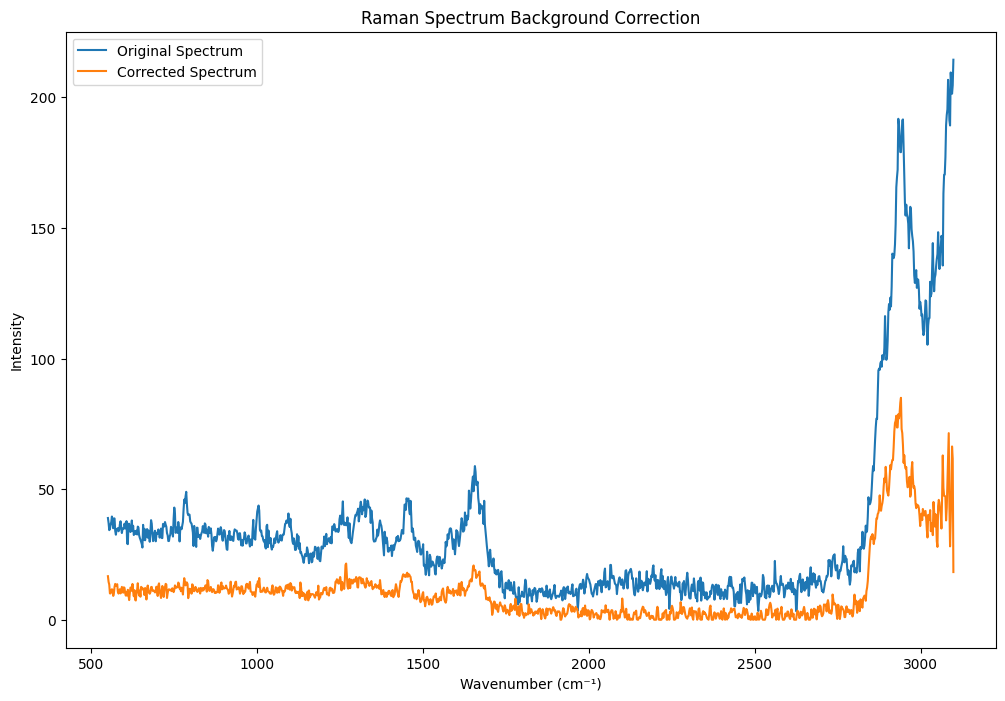

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(acotar(X_pre,550,3100).iloc[6000], label='Original Spectrum')
plt.plot(background(X_pre).iloc[6000], label='Corrected Spectrum')
plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Intensity')
plt.legend()
plt.title('Raman Spectrum Background Correction')
plt.show()

## Whittaker Eilers Smoother

In [ ]:
def whittaker_eilers_smoother(df, lmbda=100, d=2):
    def apply_whittaker_eilers_smoother(series):
        import numpy as np
        from scipy.sparse import eye, diags
        from scipy.sparse.linalg import spsolve

        y = series.values
        m = len(y)
        E = eye(m, format='csc')
        D = E[1:] - E[:-1]
        for i in range(1, d):
            D = D[1:] - D[:-1]

        H = lmbda * D.T @ D
        z = spsolve(E + H, y)
        return pd.Series(z, index=series.index, name=series.name)

    return df.apply(apply_whittaker_eilers_smoother, axis=1)

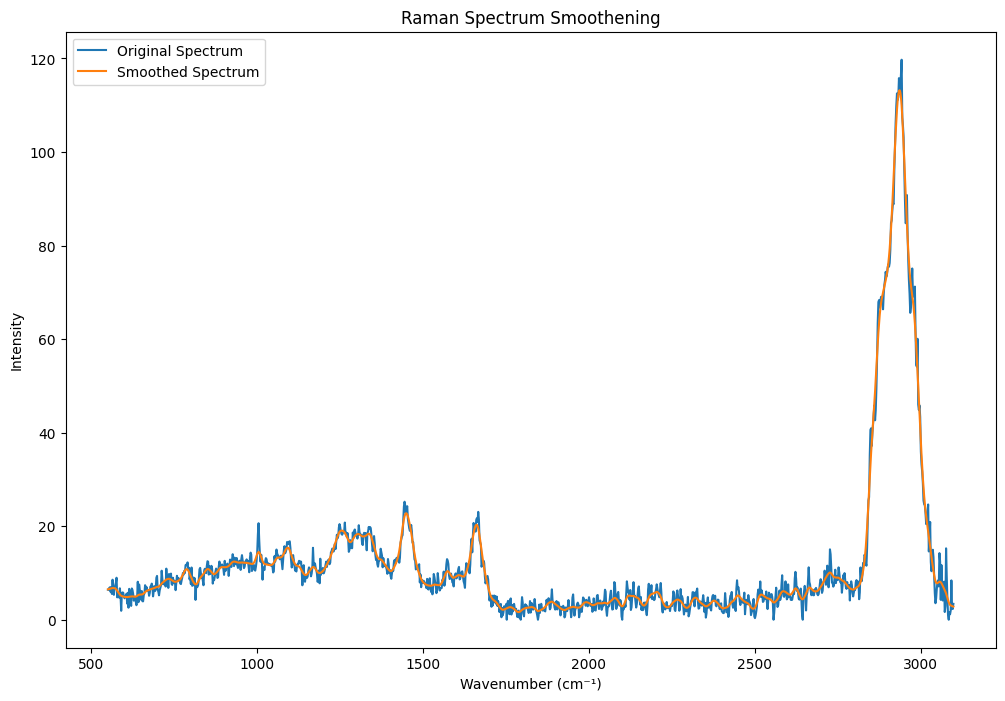

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(X_background.iloc[9000], label='Original Spectrum')
plt.plot(whittaker_eilers_smoother(X_background).iloc[9000], label='Smoothed Spectrum')
plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Intensity')
plt.legend()
plt.title('Raman Spectrum Smoothening')
plt.show()

##  Baseline correction

### Rubberband method

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull

def rubberband_baseline_correction(df):
    def apply_rubberband(series):
        x = np.arange(len(series))
        y = series.values

        v = ConvexHull(np.column_stack([x, y])).vertices
        v = np.roll(v, -v.argmin())
        v = v[:v.argmax() + 1]

        baseline = np.interp(x, x[v], y[v])
        corrected = y - baseline
        return pd.Series(corrected, index=series.index, name=series.name)

    return df.apply(apply_rubberband, axis=1)

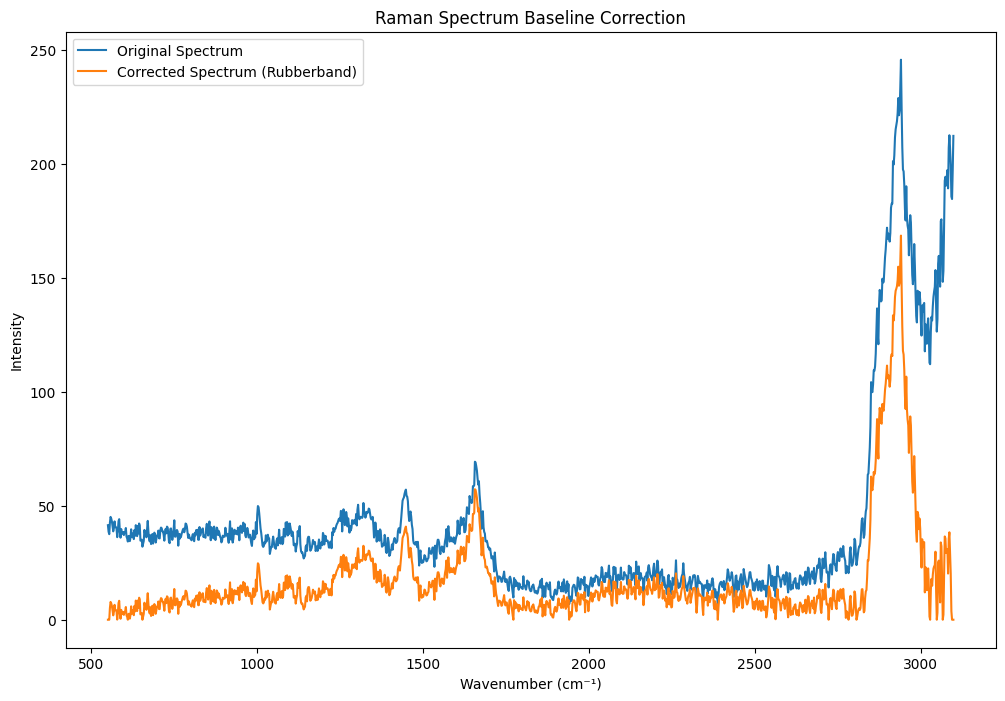

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(X_pre.iloc[7000], label='Original Spectrum')
plt.plot(rubberband_baseline_correction(X_pre).iloc[7000], label='Corrected Spectrum (Rubberband)')
plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Intensity')
plt.legend()
plt.title('Raman Spectrum Baseline Correction')
plt.show()

### SNIP (Statistics-sensitive Non-linear Iterative Peak-clipping)

In [ ]:
!pip install pybaselines

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 8.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from pybaselines import Baseline

def snip_baseline_correction(df, max_half_window=25):
    def apply_snip(series):
        y = series.values
        snip_baseline = Baseline().snip(y, max_half_window=max_half_window)[0]
        return pd.Series(y - snip_baseline, index=series.index, name=series.name)

    return df.apply(apply_snip, axis=1)

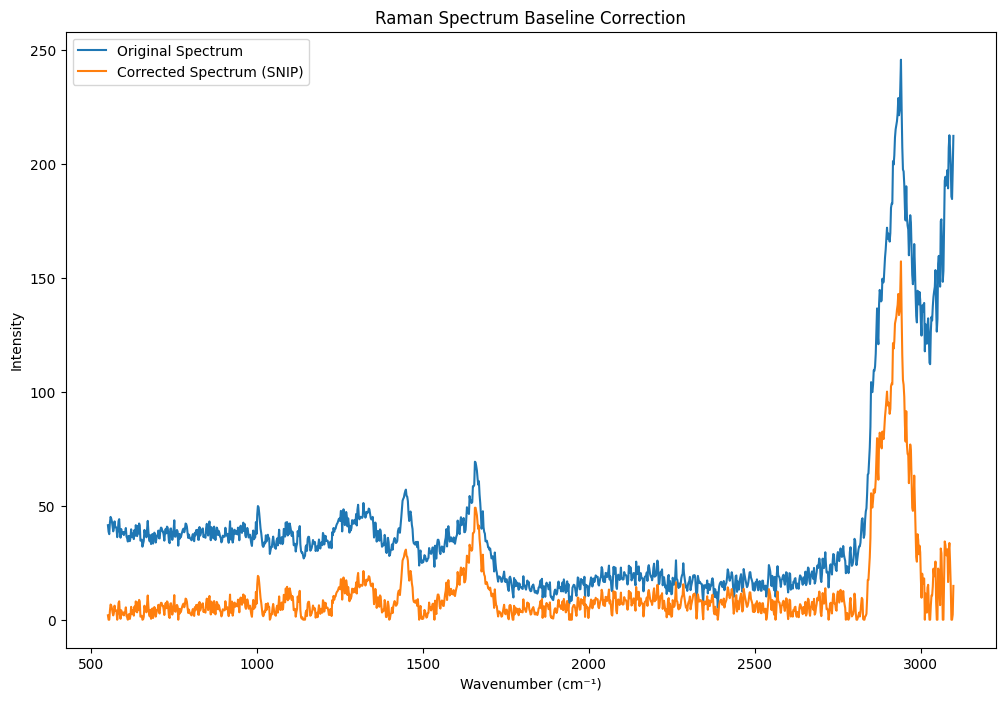

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(X_pre.iloc[7000], label='Original Spectrum')
plt.plot(snip_baseline_correction(X_pre).iloc[7000], label='Corrected Spectrum (SNIP)')
plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Intensity')
plt.legend()
plt.title('Raman Spectrum Baseline Correction')
plt.show()

### ASL

In [ ]:
import pandas as pd
from pybaselines import Baseline

def als_baseline_correction(df):
    def apply_als(series):
        y = series.values
        als_baseline = Baseline().asls(y)[0]
        return pd.Series(y - als_baseline, index=series.index, name=series.name)

    return df.apply(apply_als, axis=1)

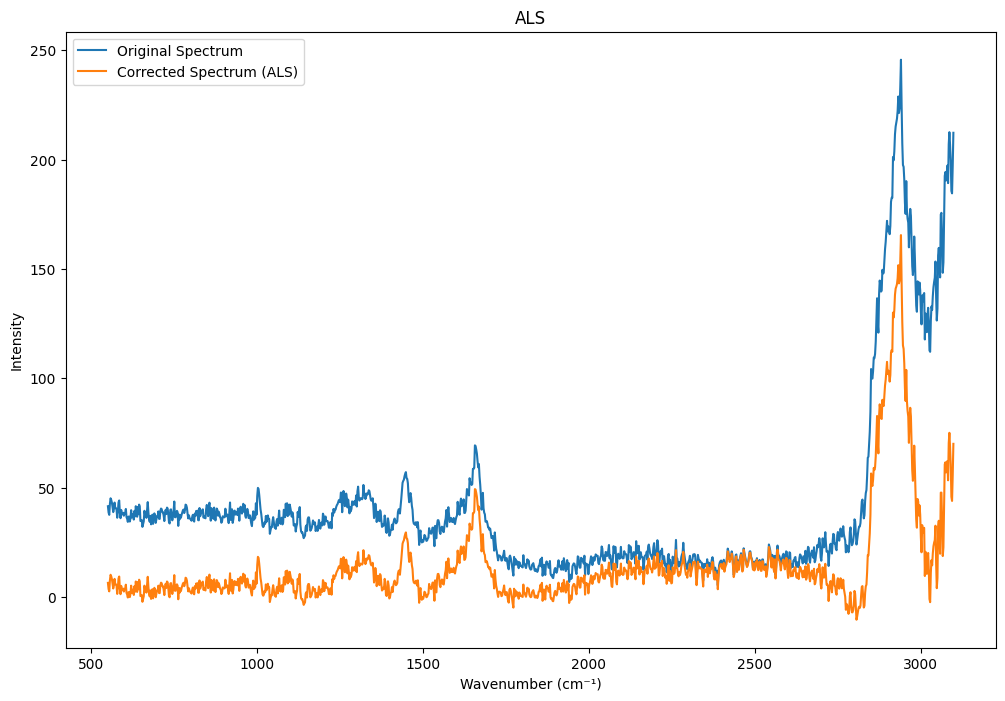

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(X_pre.iloc[7000], label='Original Spectrum')
plt.plot(als_baseline_correction(X_pre).iloc[7000], label='Corrected Spectrum (ALS)')
plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Intensity')
plt.legend()
plt.title('ALS')
plt.show()

## Normalizaciones

###  unit vector normalization (norma L2)

In [ ]:
import numpy as np
def unit_vector_normalization(X):
    def apply_unit_vector_normalization(series):
        return series / np.linalg.norm(series)

    return X.apply(apply_unit_vector_normalization, axis=1)

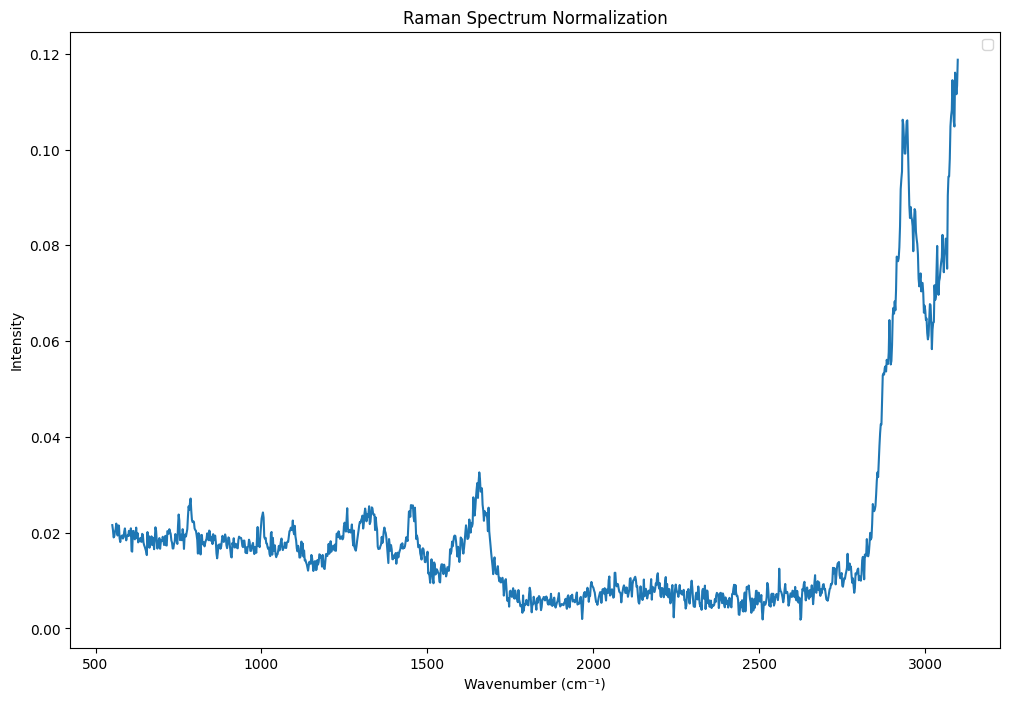

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(unit_vector_normalization(X_pre).iloc[6000])
plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Intensity')
plt.title('Raman Spectrum Normalization')
plt.show()

In [ ]:
np.linalg.norm(unit_vector_normalization(X_pre).iloc[6000])

1.0

### Min max

In [ ]:
import numpy as np

def min_max(X):
  def apply_min_max(series):
    return (series - series.min()) / (series.max() - series.min())

  return X.apply(apply_min_max, axis=1)

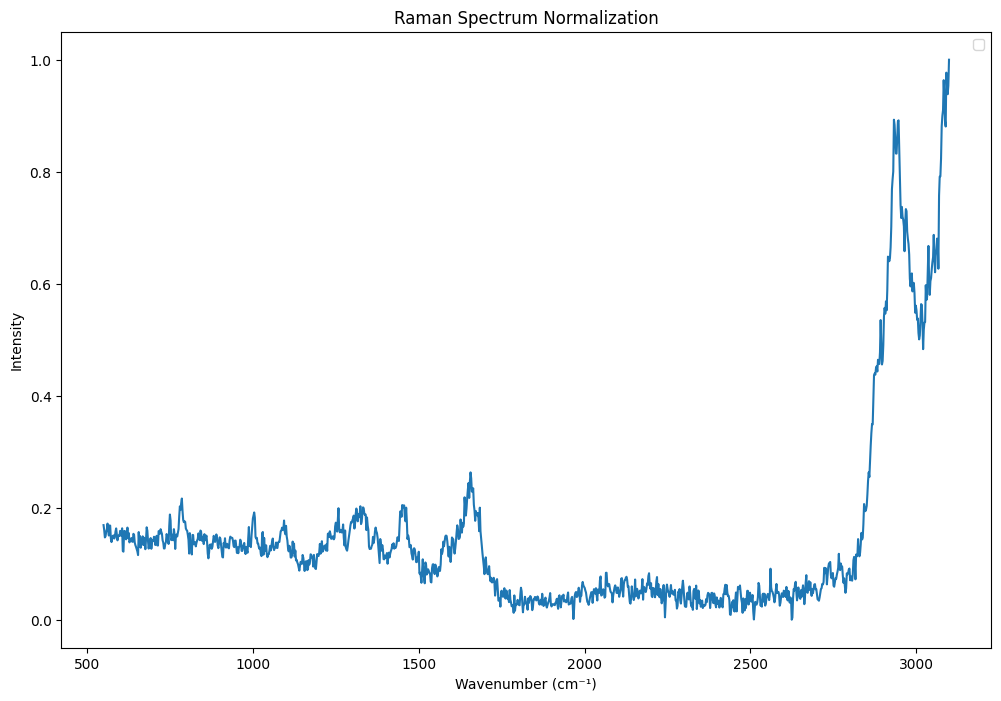

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(min_max(X_pre).iloc[6000])
plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Intensity')
plt.title('Raman Spectrum Normalization')
plt.show()

In [ ]:
min_max(X_pre).iloc[6000].describe()

,6000
count,1275.000000
mean,0.147725
std,0.175260
min,0.000000
25%,0.047910
50%,0.111651
75%,0.149522
max,1.000000


### Standarización

In [ ]:
import numpy as np

def standard(X):
    def apply_standard(series):
        return (series - series.mean()) / series.std()

    return X.apply(apply_standard, axis=1)

In [ ]:
standard(X_pre).iloc[6000].describe()

,6000
count,1.275000e+03
mean,4.458307e-17
std,1.000000e+00
min,-8.428926e-01
25%,-5.695251e-01
50%,-2.058346e-01
75%,1.025207e-02
max,4.862930e+00


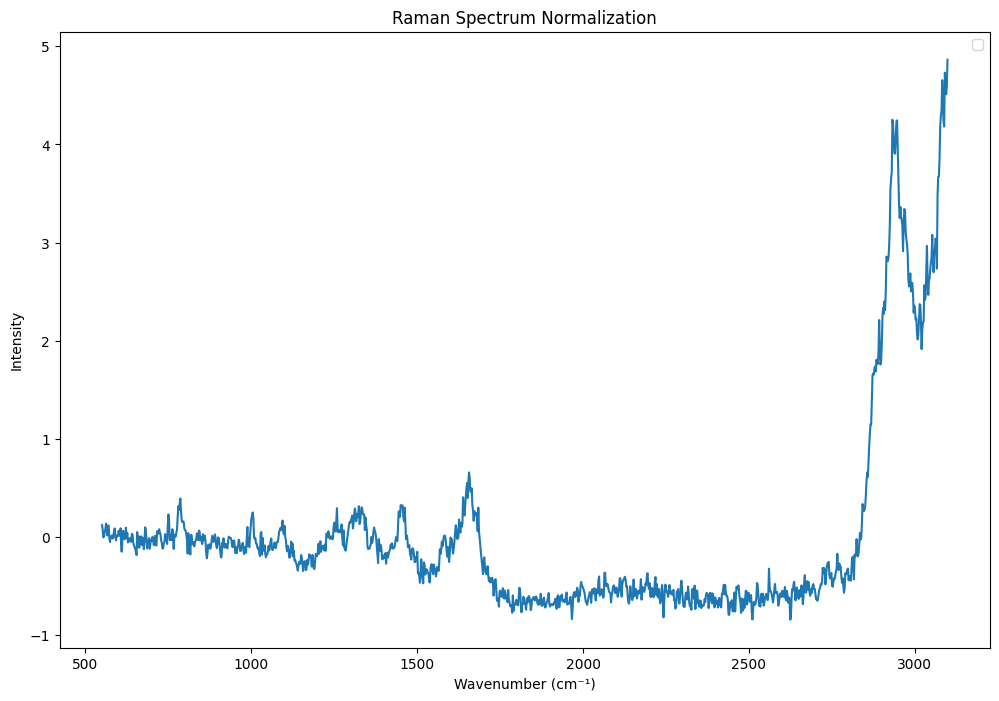

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(standard(X_pre).iloc[6000])
plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Intensity')
plt.title('Raman Spectrum Normalization')
plt.show()

## Reducción de dimensionalidad

### Factor Analysis

In [ ]:
from sklearn.decomposition import FactorAnalysis

def FactorA(X, n_components=6):
    X_reduced = FactorAnalysis(n_components=n_components).fit_transform(X)
    return pd.DataFrame(X_reduced, index=X.index, columns=[f'FA{i+1}' for i in range(n_components)])

### Independent Component Analysis (ICA)

In [ ]:
from sklearn.decomposition import FastICA

def ICA(X, n_components=6):
    X_reduced = FastICA(n_components=n_components).fit_transform(X)
    return pd.DataFrame(X_reduced, index=X.index, columns=[f'IC{i+1}' for i in range(n_components)])

### Truncated SVD

In [ ]:
from sklearn.decomposition import TruncatedSVD

def LSA(X, n_components=6):
    X_reduced = TruncatedSVD(n_components=n_components).fit_transform(X)
    return pd.DataFrame(X_reduced, index=X.index, columns=[f'LS{i+1}' for i in range(n_components)])

### Non-negative Matrix Factorization (NMF)

In [ ]:
from sklearn.decomposition import NMF
import numpy as np
import pandas as pd
"""
Dado que el standard scaler me va a dar numero negativos (inevitable con media 0),
para hacerlo compatible muevo los datos para que el minimo del dataframe sea 0.
Podria poner a estos dos preprocesados como incompatibles en el apartado posterior de comparativa,
pero dado que el arreglo es muy sencillo no hace falta esta restricción
"""

def NMF_f(X, n_components=6):
    # Movemos los datos para que el minimo sea 0
    min_value = X.min().min()
    if min_value < 0:
        X_shifted = X - min_value
    else:
        X_shifted = X

    # Apply NMF
    X_reduced = NMF(n_components=n_components).fit_transform(X_shifted)

    return pd.DataFrame(X_reduced, index=X.index, columns=[f'NMF{i+1}' for i in range(n_components)])

### Principal Component Analysis (PCA)

In [ ]:
from sklearn.decomposition import PCA

def PCA_f(X, n_components=6):
    X_reduced = PCA(n_components=n_components).fit_transform(X)
    return pd.DataFrame(X_reduced, index=X.index, columns=[f'PC{i+1}' for i in range(n_components)])

### Incremental PCA (PCA_inc)

In [ ]:
from sklearn.decomposition import IncrementalPCA

def PCA_inc(X, n_components=6, batch_size=None):
    X_reduced = IncrementalPCA(n_components=n_components, batch_size=batch_size).fit_transform(X)
    return pd.DataFrame(X_reduced, index=X.index, columns=[f'PC{i+1}' for i in range(n_components)])

### Sparse PCA (PCA_sp)

In [ ]:
from sklearn.decomposition import SparsePCA

def PCA_sp(X, n_components=6):
    X_reduced = SparsePCA(n_components=n_components).fit_transform(X)
    return pd.DataFrame(X_reduced, index=X.index, columns=[f'SPC{i+1}' for i in range(n_components)])


# Comparativa de algoritmos

## Comparación de los posibles preprocesados

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings

# Suppress only ConvergenceWarnings
from sklearn.exceptionimport times import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Defino funciones para combinar los pasos de preprocesado y aplicarlos a un DataFrame
def generate_preprocessing_combinations(preprocessing_steps, exclude_groups):
    import itertools
    combinations = []
    for L in range(1, len(preprocessing_steps)+1):
        for subset in itertools.combinations(preprocessing_steps, L):
            if not any(all(step in subset for step in group) for group in exclude_groups):
                combinations.append(subset)
    return combinations


def perform_classification(transformed_data, labels):
    X_train, X_test, y_train, y_test = train_test_split(transformed_data, labels[transformed_data.index], test_size=0.2, random_state=42)
    model = LogisticRegression(random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, FastICA, NMF, SparsePCA, IncrementalPCA, FactorAnalysis, TruncatedSVD
# Se definen las funciones que usare en el preprocesado
def acotado_600_1800(X): return acotar(X,600,1800)
def acotado_2800_3030(X): return acotar(X,2800,3030)

# Se declaran los pasos de procesado que se quieren combinar, incluyendo reducción de dimensionalidad
preprocessing_steps = [
    # Funcionees de acotado
    acotado_600_1800,
    acotado_2800_3030,
    # Background
    background,
    # Baseline correction
    rubberband_baseline_correction,
    snip_baseline_correction,
    als_baseline_correction,
    # Smoother
    whittaker_eilers_smoother,
    # Normalizaciones
    unit_vector_normalization,
    min_max,
    standard,
    # Reducción de dimensionalidad
    FactorA,
    ICA,
    LSA,
    NMF_f,
    PCA_f,
    PCA_inc,
    PCA_sp,
]

# Se aplican restricciones para seleccionar solo una normalización, una técnica de reducción de dimensionalidad, un tipo de acotamineto espectral y otras incompatibilidades
exclude_groups = [
    # Restricciones de normalización
    (unit_vector_normalization, standard),
    (unit_vector_normalization, min_max),
    (standard, min_max),
    # Restricciones de acotado y background
    (acotado_600_1800, acotado_2800_3030),
    (acotado_600_1800, background),
    # Restricciones para baseline
    (rubberband_baseline_correction, snip_baseline_correction),
    (rubberband_baseline_correction, als_baseline_correction),
    (snip_baseline_correction, als_baseline_correction),
    # Restricciones para técnicas de reducción de dimensionalidad
    (FactorA, ICA),
    (FactorA, LSA),
    (FactorA, NMF_f),
    (FactorA, PCA_f),
    (FactorA, PCA_inc),
    (FactorA, PCA_sp),
    (ICA, LSA),
    (ICA, NMF_f),
    (ICA, PCA_f),
    (ICA, PCA_inc),
    (ICA, PCA_sp),
    (LSA, NMF_f),
    (LSA, PCA_f),
    (LSA, PCA_inc),
    (LSA, PCA_sp),
    (NMF_f, PCA_f),
    (NMF_f, PCA_inc),
    (NMF_f, PCA_sp),
    (PCA_f, PCA_inc),
    (PCA_f, PCA_sp),
    (PCA_inc, PCA_sp),
]

In [ ]:
combinations

[(<function __main__.acotado_600_1800(X)>,),
 (<function __main__.acotado_2800_3030(X)>,),
 (<function __main__.background(data, clustering_min=2800, clustering_max=3030)>,),
 (<function __main__.rubberband_baseline_correction(df)>,),
 (<function __main__.snip_baseline_correction(df, max_half_window=25)>,),
 (<function __main__.als_baseline_correction(df)>,),
 (<function __main__.whittaker_eilers_smoother(df, lmbda=100, d=2)>,),
 (<function __main__.unit_vector_normalization(X)>,),
 (<function __main__.min_max(X)>,),
 (<function __main__.standard(X)>,),
 (<function __main__.FactorA(X, n_components=6)>,),
 (<function __main__.ICA(X, n_components=6)>,),
 (<function __main__.LSA(X, n_components=6)>,),
 (<function __main__.NMF_f(X, n_components=6)>,),
 (<function __main__.PCA_f(X, n_components=6)>,),
 (<function __main__.PCA_inc(X, n_components=6, batch_size=None)>,),
 (<function __main__.PCA_sp(X, n_components=6)>,),
 (<function __main__.acotado_600_1800(X)>,
  <function __main__.rubberba

### Algunas pruebas...

In [ ]:
import pandas as pd
from joblib import Parallel, delayed
import random
import time
start=time.time()

def apply_and_evaluate(combo, data, labels):
    try:
        # Copia de los datos y etiquetas
        data_copy = data.copy()
        y_copy = labels.copy()

        # Aplicar cada paso de la combinación
        for step in combo:
            data_copy = step(data_copy)

        # Evaluar la precisión usando la función de clasificación
        accuracy = perform_classification(data_copy, y_copy)
        return combo, accuracy

    except Exception as e:
        print(f"Error en {combo}, con error: {e}")
        return combo, None


#combinations = generate_preprocessing_combinations(preprocessing_steps,exclude_groups)
combinations = random.sample(combinations, 10)
# Aplicar las combinaciones en paralelo y almacenar los resultados
results = dict(Parallel(n_jobs=-1)(delayed(apply_and_evaluate)(combo, X_pre, y) for combo in combinations))
end=time.time()
print('tiempo estimado: ', (end-start)*len(combinations)/10)


tiempo estimado:  159.61609387397766


In [81]:
results

{(<function __main__.background(data, clustering_min=2800, clustering_max=3030)>,
  <function __main__.min_max(X)>,
  <function __main__.NMF_f(X, n_components=6)>): 0.8191279887482419,
 (<function __main__.background(data, clustering_min=2800, clustering_max=3030)>,
  <function __main__.whittaker_eilers_smoother(df, lmbda=100, d=2)>,
  <function __main__.unit_vector_normalization(X)>,
  <function __main__.PCA_inc(X, n_components=6, batch_size=None)>): 0.9172995780590717,
 (<function __main__.als_baseline_correction(df)>,
  <function __main__.whittaker_eilers_smoother(df, lmbda=100, d=2)>,
  <function __main__.FactorA(X, n_components=6)>): 0.8737284687372847,
 (<function __main__.background(data, clustering_min=2800, clustering_max=3030)>,
  <function __main__.whittaker_eilers_smoother(df, lmbda=100, d=2)>,
  <function __main__.LSA(X, n_components=6)>): 0.8869198312236287,
 (<function __main__.acotado_2800_3030(X)>,
  <function __main__.background(data, clustering_min=2800, clustering_m

In [ ]:
len(combinations)

1279

In [82]:
invalid_combinations = []
for combo in combinations:
    for exclude_group in exclude_groups:
        if all(step in combo for step in exclude_group):
            invalid_combinations.append(combo)

print(len(invalid_combinations))

0


## Diccionario a DataFrame (importante para hacer la comparación!!!)

In [ ]:
import pandas as pd

function_to_name = {
    acotado_600_1800: 'acotado_600_1800',
    acotado_2800_3030: 'acotado_2800_3030',
    background: 'background',
    rubberband_baseline_correction: 'rubberband_baseline_correction',
    snip_baseline_correction: 'snip_baseline_correction',
    als_baseline_correction: 'als_baseline_correction',
    whittaker_eilers_smoother: 'whittaker_eilers_smoother',
    unit_vector_normalization: 'unit_vector_normalization',
    min_max: 'min_max',
    standard: 'standard',
    FactorA: 'FactorA',
    ICA: 'ICA',
    LSA: 'LSA',
    NMF_f: 'NMF_f',
    PCA_f: 'PCA_f',
    PCA_inc: 'PCA_inc',
    PCA_sp: 'PCA_sp'
}

# Función para convertir los resultados en un DataFrame con pasos agrupados
def results_to_grouped_dataframe(results, step_groups):
    # Mapear las combinaciones de funciones a nombres
    mapped_results = {
        tuple(function_to_name.get(step, step.__name__) for step in combo): accuracy
        for combo, accuracy in results.items()
    }

    # Extraer todos los pasos únicos que no están en grupos
    all_steps = set(step for combo in mapped_results.keys() for step in combo)

    # Obtener las columnas agrupadas y los pasos individuales
    grouped_columns = list(step_groups.keys())
    grouped_steps = set(step for group in step_groups.values() for step in group)

    # Convertir los pasos individuales a nombres de cadena para ordenarlos
    individual_steps = sorted(all_steps - grouped_steps)

    # Inicializar una lista vacía para almacenar las filas del DataFrame
    data_rows = []

    # Iterar a través de cada combinación y su precisión correspondiente
    for combo, accuracy in mapped_results.items():
        row_data = {}

        # Manejar las columnas agrupadas
        for col_name, steps in step_groups.items():
            step_in_combo = [step for step in steps if step in combo]
            row_data[col_name] = step_in_combo[0] if step_in_combo else None

        # Manejar los pasos individuales (que no son parte de ningún grupo)
        for step in individual_steps:
            row_data[step] = 1 if step in combo else 0

        # Agregar la precisión (accuracy) a la fila
        row_data['accuracy'] = accuracy
        data_rows.append(row_data)

    df = pd.DataFrame(data_rows)

    return df


# Definir los grupos de pasos
step_groups = {
    'Normalizacion': ['unit_vector_normalization', 'min_max', 'standard'],
    'Acotacion': ['acotado_600_1800', 'acotado_2800_3030'],
    'Baseline_Correction': ['rubberband_baseline_correction', 'snip_baseline_correction', 'als_baseline_correction'],
    'Reduccion_de_dimensionalidad': ['FactorA', 'ICA', 'LSA', 'NMF_f', 'PCA_f', 'PCA_inc', 'PCA_sp']
}

# Asumiendo que 'results' es tu diccionario con combinaciones de preprocesamiento y sus precisiones
df_results = results_to_grouped_dataframe(results, step_groups)

In [83]:
results

{(<function __main__.background(data, clustering_min=2800, clustering_max=3030)>,
  <function __main__.min_max(X)>,
  <function __main__.NMF_f(X, n_components=6)>): 0.8191279887482419,
 (<function __main__.background(data, clustering_min=2800, clustering_max=3030)>,
  <function __main__.whittaker_eilers_smoother(df, lmbda=100, d=2)>,
  <function __main__.unit_vector_normalization(X)>,
  <function __main__.PCA_inc(X, n_components=6, batch_size=None)>): 0.9172995780590717,
 (<function __main__.als_baseline_correction(df)>,
  <function __main__.whittaker_eilers_smoother(df, lmbda=100, d=2)>,
  <function __main__.FactorA(X, n_components=6)>): 0.8737284687372847,
 (<function __main__.background(data, clustering_min=2800, clustering_max=3030)>,
  <function __main__.whittaker_eilers_smoother(df, lmbda=100, d=2)>,
  <function __main__.LSA(X, n_components=6)>): 0.8869198312236287,
 (<function __main__.acotado_2800_3030(X)>,
  <function __main__.background(data, clustering_min=2800, clustering_m

In [ ]:
df_results

,Normalizacion,Acotacion,Baseline_Correction,Reduccion_de_dimensionalidad,background,whittaker_eilers_smoother,accuracy
0,min_max,None,None,NMF_f,1,0,0.819128
1,unit_vector_normalization,None,None,PCA_inc,1,1,0.917300
2,None,None,als_baseline_correction,FactorA,0,1,0.873728
3,None,None,None,LSA,1,1,0.886920
4,None,acotado_2800_3030,None,FactorA,1,1,0.806470
5,min_max,acotado_2800_3030,None,ICA,1,1,0.677637
6,unit_vector_normalization,acotado_600_1800,rubberband_baseline_correction,None,0,1,0.749356
7,None,None,snip_baseline_correction,FactorA,0,1,0.831954
8,standard,acotado_2800_3030,None,FactorA,0,1,0.421674
9,unit_vector_normalization,acotado_2800_3030,als_baseline_correction,PCA_f,0,1,0.398210


------------------------------------

In [ ]:
from sklearn.externals import joblib

joblib.dump(results, '/content/drive/MyDrive/TFM/preprocesado/X_combinaciones.feather')

In [ ]:
from sklearn.decomposition import PCA, FastICA, NMF, LatentDirichletAllocation, SparsePCA, IncrementalPCA, FactorAnalysis, TruncatedSVD
from sklearn.cross_decomposition import PLSRegression,PLSCanonical, PLSSVD
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score

# probar diferentes normalizaciones y preprocesados del notebook inicial


# MinMax Scaler for NMF (non-negative matrix factorization)
scaler_minmax = MinMaxScaler()
scaled_data_minmax = scaler_minmax.fit_transform(X_samp)

# Encode the target labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Encode y to numerical labels

# Function to perform classification and print scores


scores_PCA = []
scores_ICA = []
scores_PLS_reg = []
scores_PLS_SVD=[]
scores_NMF = []
scores_PCA_inc = []
scores_PCA_sp = []
scores_fact = []
scores_LSA = []

#partition for supervised models
X_train, X_test, y_train, y_test = train_test_split(scaled_data_minmax, y_encoded, test_size=0.3, random_state=42)

for n in range(1, 9):

  fact= FactorAnalysis(n_components=n)
  fact_result = fact.fit_transform(scaled_data_minmax)
  scores_fact.append(perform_classification(fact_result, y_encoded, "fact")) # Use encoded y

  lsa = TruncatedSVD(n_components=n)
  lsa_result = lsa.fit_transform(scaled_data_minmax)
  scores_LSA.append(perform_classification(lsa_result, y_encoded, "lsa")) # Use encoded y
  # 1. Principal Component Analysis (PCA)
  pca = PCA(n_components=n)
  pca_result = pca.fit_transform(scaled_data_minmax)
  scores_PCA.append(perform_classification(pca_result, y_encoded, "PCA")) # Use encoded y

  # 1. Principal Component Analysis (PCA)
  pca_inc = IncrementalPCA(n_components=n)
  pca_inc_result = pca_inc.fit_transform(scaled_data_minmax)
  scores_PCA_inc.append(perform_classification(pca_inc_result, y_encoded, "PCA inc"))

  # 1. Principal Component Analysis (PCA)
  pca_sp = SparsePCA(n_components=n)
  pca_sp_result = pca_sp.fit_transform(scaled_data_minmax)
  scores_PCA_sp.append(perform_classification(pca_sp_result, y_encoded, "sparsePCA"))

  # 2. Independent Component Analysis (ICA)
  ica = FastICA(n_components=n)  # Reduce to 2 components
  ica_result = ica.fit_transform(scaled_data_minmax)
  scores_ICA.append(perform_classification(ica_result, y_encoded, "ICA")) # Use encoded y

  # 4. Partial Least Squares (PLS)
  pls_reg = PLSRegression(n_components=n)  # Reduce to 2 components
  pls_reg.fit(X_train,y_train)
  pls_reg_result=pls_reg.transform(X_test)
  scores_PLS_reg.append(perform_classification(pls_reg_result,y_test, "PLS")) # Use encoded y

  # 5. Non-Negative Matrix Factorization (NMF)
  nmf = NMF(n_components=n)  # Reduce to 2 components
  nmf_result = nmf.fit_transform(scaled_data_minmax)
  scores_NMF.append(perform_classification(nmf_result, y_encoded, "NMF")) # Use encoded y
  print(n)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocess

2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

3


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

4


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

6


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

7


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

8


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


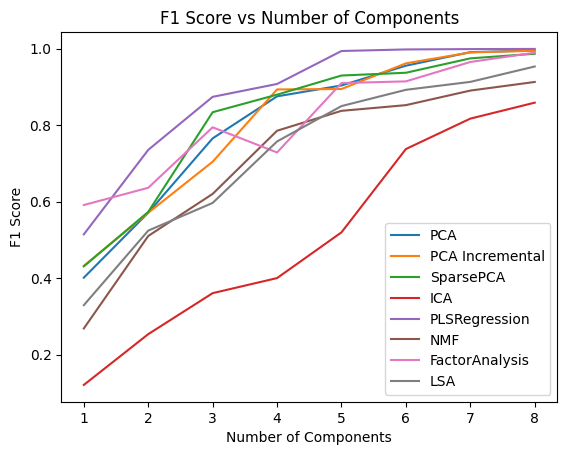

In [ ]:
import matplotlib.pyplot as plt


plt.plot(range(1,9),pd.DataFrame(scores_PCA)[1],label='PCA')
plt.plot(range(1,9),pd.DataFrame(scores_PCA_inc)[1],label='PCA Incremental')
plt.plot(range(1,9),pd.DataFrame(scores_PCA_sp)[1],label='SparsePCA')
plt.plot(range(1,9),pd.DataFrame(scores_ICA)[1],label='ICA')
plt.plot(range(1,9),pd.DataFrame(scores_PLS_reg)[1],label='PLSRegression')
plt.plot(range(1,9),pd.DataFrame(scores_NMF)[1],label='NMF')
plt.plot(range(1,9),pd.DataFrame(scores_fact)[1],label='FactorAnalysis')
plt.plot(range(1,9),pd.DataFrame(scores_LSA)[1],label='LSA')
plt.title('F1 Score vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

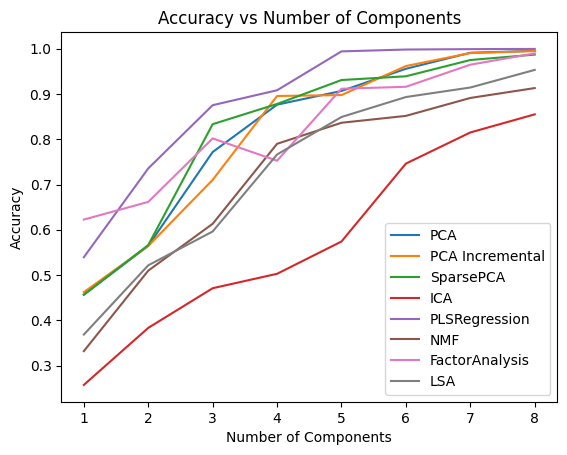

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1,9),pd.DataFrame(scores_PCA)[0],label='PCA')
plt.plot(range(1,9),pd.DataFrame(scores_PCA_inc)[0],label='PCA Incremental')
plt.plot(range(1,9),pd.DataFrame(scores_PCA_sp)[0],label='SparsePCA')
plt.plot(range(1,9),pd.DataFrame(scores_ICA)[0],label='ICA')
plt.plot(range(1,9),pd.DataFrame(scores_PLS_reg)[0],label='PLSRegression')
plt.plot(range(1,9),pd.DataFrame(scores_NMF)[0],label='NMF')
plt.plot(range(1,9),pd.DataFrame(scores_fact)[0],label='FactorAnalysis')
plt.plot(range(1,9),pd.DataFrame(scores_LSA)[0],label='LSA')
plt.title('Accuracy vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.legend()


Parece que el odren es:
  1. **PLS**: Es de esperar que sea el mejor pues es una reduccion de dimensionalidad supervisada y el resto son no supervisadas.
  2. **PCA** en sus 3 variantes son similares
  3. **FactorAnalysis**: Similar a PCA, pero en n=4 rinde ligeramnte peor.
  4. **NMF** y **LSA** rinde similar.
  5. **ICA** es el peor de todos.